## Import Dependencies

In [127]:
from sklearn.datasets import fetch_20newsgroups

## Generate Training Data

In [128]:
categories_train = ['comp.graphics', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'comp.windows.x']
train_data = fetch_20newsgroups(subset='train', categories=categories_train)['data']

`train_data` has queries related only to computers. Your task is train a model to reject queries outside this domain. The classifier must output 1 for queries in domain and -1 for queries which are out of domain

## Your solution from here. Good Luck !

In [129]:
len(train_data)

2345

In [130]:
import pickle
import random
import numpy as np
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,fbeta_score,precision_score,roc_auc_score,recall_score
import matplotlib.pyplot as plt
%matplotlib inline
#pickle.dump(train_data,open('train_data','wb'))

Getting data from other categories used as outliers in the training and test data

In [131]:
others=fetch_20newsgroups(subset='train',categories=['alt.atheism', 'rec.sport.baseball','rec.autos','misc.forsale','sci.med'])['data']
#others=random.sample(others,200)
#pickle.dump(others,open('outliers','wb'))

In [133]:
len(others)

2850

Making a function for cleaning textual data

In [134]:
def letter_only(string):
    return string.isalpha()
def clean_data(text):
    cleaned=[]
    all_names=set(names.words())
    lemmatizer=WordNetLemmatizer()
    for item in text:
        cleaned.append(' '.join([lemmatizer.lemmatize(word.lower()) for word in item.split() if letter_only(word) and word not in all_names]))
    return cleaned

In [135]:
train_cleaned=clean_data(train_data)
outliers_cleaned=clean_data(others)

In [136]:
train_cleaned[200]

'lcd overhead projector the university of british columbia na in am looking for one of those color lcd screen you on an overhead projector and control the presentation a you recommend me a particular price are we talking for a good you get an active matrix panel and a bright overhead projector designed to be used with an lcd panel stage must not get too i tried out a proxima ovation unit and liked but i needed a brighter projector used it with a it is also too expensive for what you price of active matrix panel are rumoured to drop substantially sometime this year to do with tarrifs being lifted i in canadian the proxima ovation model ranged in price from about to and a good overhead projector about to for that kind of you can get a brighter image from a three beam but sacrifice oh proper room lighting is extremely especially if you want your audience to have enough light to read handout and not have that light wash out your display at the front of the tricky to get'

Making another function for keeping only nouns in the datasets. Reasoning behind this was that information about domain/category is usually in the nouns in a document. (not used because it did not improve accuracy)

In [137]:
def preprocess(text):
    preprocessed=[]
    for item in text:
        tokenizer = RegexpTokenizer(r'\w+') 
        tokenized = tokenizer.tokenize(item)
        tagged=nltk.pos_tag(tokenized)
        nouns=[]
        for tag in tagged:
        #words with POS tags beginning with N are nouns
            if re.search(r'^N',tag[1]):
                nouns.append(tag[0])
        preprocessed.append(nouns)
    preprocessed=[' '.join(article) for article in preprocessed]
    return preprocessed

In [15]:
#train_pp=preprocess(train_cleaned)
#test_pp=preprocess(test_cleaned)
#outlier_pp=preprocess(outliers_cleaned)

Converting the textual data into tfidf vectors and reducing the dimension

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
vectorizer = TfidfVectorizer(stop_words='english')#,max_features=100)
trainv=vectorizer.fit_transform(train_cleaned)
svd=TruncatedSVD(n_components=120)
svd.fit(trainv)
trainv=svd.transform(trainv)
outliersv=vectorizer.transform(outliers_cleaned)
outliersv=svd.transform(outliersv)

For the sake of simplicity, we are considering the following labels in our datasets:
1 for outlier,
0 for inlier

In [139]:
y_train=list(np.zeros(len(train_pp)))
y_outliers=list(np.ones(len(outlier_pp)))

Mixing some outliers into the training data for better classification

In [140]:
totalx=np.concatenate((trainv,outliersv))
totaly=np.concatenate((y_train,y_outliers))
train_val_x,test_x,train_val_y,test_y=train_test_split(totalx,totaly,test_size=0.2,random_state=42)
train_x,val_x,train_y,val_y=train_test_split(train_val_x,train_val_y,test_size=0.2,random_state=42)

In [141]:
train_x.shape

(3324, 120)

In [142]:
print('Train shape: ', train_x.shape)
print('Proportion of outliers in training set: %.2f\n' % np.mean(train_y))
print('Valid shape: ', val_x.shape)
print('Proportion of outliers in validation set: %.2f\n' % np.mean(val_y))
print('Test shape:, ', test_x.shape)
print('Proportion of outliers in test set: %.2f\n' % np.mean(test_y))

Train shape:  (3324, 120)
Proportion of outliers in training set: 0.55

Valid shape:  (832, 120)
Proportion of outliers in validation set: 0.56

Test shape:,  (1039, 120)
Proportion of outliers in test set: 0.54



Checking out IsolationForest for outlier detection

In [143]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(random_state=42, n_jobs=-1, bootstrap=True, n_estimators=5)
model.fit(train_x,train_y)

IsolationForest(bootstrap=True, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=5, n_jobs=-1, random_state=42,
        verbose=0)

Checking for the best threshold

In [144]:
thresholds = np.linspace(0, .5, 200)
y_scores = model.decision_function(val_x)
scores = []
for threshold in thresholds:
    y_hat = (y_scores < threshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=val_y),
                 precision_score(y_pred=y_hat, y_true=val_y),
                 fbeta_score(y_pred=y_hat, y_true=val_y, beta=1)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.715057915058 65


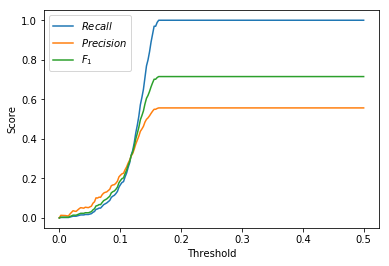

In [145]:
plt.plot(thresholds, scores[:, 0], label='$Recall$')
plt.plot(thresholds, scores[:, 1], label='$Precision$')
plt.plot(thresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [146]:
final_thresh = thresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test_x) < final_thresh).astype(int)

print('Final threshold: %f' % final_thresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test_y))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test_y))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test_y, beta=1))


Final threshold: 0.163317
Test Recall Score: 1.000
Test Precision Score: 0.539
Test F1 Score: 0.700


Any of the other outlier detection method like OneClassSVM also gave similar results.

So considering it as a classical classification problem.(We have mixed our training data with outliers and also labelled them. So we can now use simple classification models) 

Trying with a straightforward BaggingClassifier model

In [153]:
model=BaggingClassifier(n_jobs=-1,n_estimators=100)
model.fit(train_x,train_y)
from sklearn.metrics import accuracy_score,fbeta_score,precision_score,roc_auc_score,recall_score
thresholds = np.linspace(0, 1, 200)
y_scores = model.predict_proba(val_x)
scores = []
for threshold in thresholds:
    y_hat = (y_scores < threshold).astype(int)[:,0]
    scores.append([recall_score(y_pred=y_hat, y_true=val_y.astype(int)),
                 precision_score(y_pred=y_hat, y_true=val_y),
                 fbeta_score(y_pred=y_hat, y_true=val_y, beta=1)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.910869565217 110


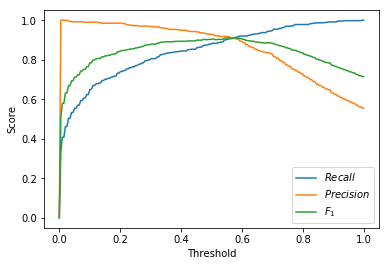

In [154]:
plt.plot(thresholds, scores[:, 0], label='$Recall$')
plt.plot(thresholds, scores[:, 1], label='$Precision$')
plt.plot(thresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [155]:
final_thresh = thresholds[scores[:, 2].argmax()]
y_hat_test = (model.predict_proba(test_x) < final_thresh).astype(int)[:,0]

print('Final threshold: %f' % final_thresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test_y))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test_y))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test_y, beta=1))


Final threshold: 0.552764
Test Recall Score: 0.912
Test Precision Score: 0.927
Test F1 Score: 0.920


Giving far better results than the above outlier detection models. So doing a grid search on the parameters of BaggingClassifier

In [94]:
param_grid = {'n_estimators' : [10, 50, 100, 200], 'max_samples':[0.2, 0.5, 0.8, 1], 'max_features':[0.2, 0.5, 0.8, 1]}
gridsearch = GridSearchCV(BaggingClassifier(n_jobs=-1), param_grid, cv=5)
gridsearch.fit(train_val_x,train_val_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 200], 'max_samples': [0.2, 0.5, 0.8, 1], 'max_features': [0.2, 0.5, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [123]:
gridsearch.best_params_

{'max_features': 0.2, 'max_samples': 0.5, 'n_estimators': 200}

Best parameters for the BaggingClassifier are {'max_features': 0.2, 'max_samples': 0.5, 'n_estimators': 200}

In [124]:
gridsearch.best_score_

0.91867179980750724

In [ ]:
#model=BaggingClassifier(max_features=0.2,max_samples=0.5,n_estimators=200,n_jobs=-1)
#model.fit(train_val_x,train_val_y)

In [157]:
model=gridsearch.best_estimator_
thresholds = np.linspace(0, 1, 200)
y_scores = model.predict_proba(val_x)
scores = []
for threshold in thresholds:
    y_hat = (y_scores < threshold).astype(int)[:,0]
    scores.append([recall_score(y_pred=y_hat, y_true=val_y.astype(int)),
                 precision_score(y_pred=y_hat, y_true=val_y),
                 fbeta_score(y_pred=y_hat, y_true=val_y, beta=1)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.997840172786 95


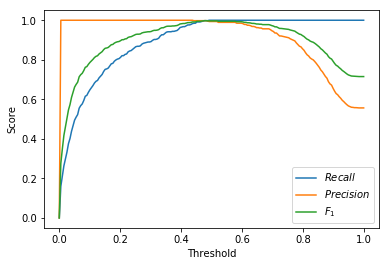

In [158]:
plt.plot(thresholds, scores[:, 0], label='$Recall$')
plt.plot(thresholds, scores[:, 1], label='$Precision$')
plt.plot(thresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [159]:
final_thresh = thresholds[scores[:, 2].argmax()]
y_hat_test = (model.predict_proba(test_x) < final_thresh).astype(int)[:,0]

print('Final threshold: %f' % final_thresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test_y))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test_y))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test_y, beta=1))


Final threshold: 0.477387
Test Recall Score: 0.895
Test Precision Score: 0.956
Test F1 Score: 0.924


Testing the model on new test containing only outliers. (data created from other categories) 

In [165]:
new_test=fetch_20newsgroups(subset='train',categories=['rec.sport.hockey','sci.electronics','sci.space'])['data']
new_test_cleaned = clean_data(new_test)
new_testv=vectorizer.transform(new_test_cleaned)
new_testv=svd.transform(new_testv)
y_new_test=list(np.ones(len(new_test_cleaned)))

In [166]:
new_testv.shape

(1784, 120)

In [167]:
y_hat_new_test=(model.predict_proba(new_testv) < final_thresh).astype(int)[:,0]
accuracy_score(y_pred=y_hat_new_test,y_true=y_new_test)

0.87331838565022424

Testing the model on another data containing text only from the computer domain. (data created from 'comp.os.ms-windows.misc' category in newsgroup data)

In [164]:
new_test2=fetch_20newsgroups(subset='train',categories=['comp.os.ms-windows.misc'])['data']
new_test2_cleaned = clean_data(new_test2)
new_test2v=vectorizer.transform(new_test2_cleaned)
new_test2v=svd.transform(new_test2v)
y_new_test2=list(np.zeros(len(new_test2_cleaned)))
y_hat_new_test2=(model.predict_proba(new_test2v) < final_thresh).astype(int)[:,0]
accuracy_score(y_pred=y_hat_new_test2,y_true=y_new_test2)

0.82910321489001693

Good enough for now. Other classification models can also be considered. Boosting, SVM, NaiveBayesClassifier etc.

The following function converts the labels in the desired format: -1 for outlier , 1 for inlier

In [172]:
def map_output(predicted):
    output=[-1 if x==1 else 1 for x in predicted]
    return output

So this is our final model as a function.

In [185]:
def predict_outlier(data,model,threshold):
    data_list=[]
    data_list.append(data)
    data_cleaned=clean_data(data_list)
    data_vect=vectorizer.transform(data_cleaned)
    data_vect=svd.transform(data_vect)
    predicted_labels=(model.predict_proba(data_vect)<threshold).astype(int)[:,0]
    predicted_labels=map_output(predicted_labels)
    return predicted_labels[0]

An example use of the function

In [190]:
data=['My name is aman mahajan.',
      ' I love machine learning and data science. But I need a better laptop.',
      ' Artificial intelligence is the future.',
      'Today India lost a test cricket match against south africa. India also lost the 3 match series 2-0 with one match still left to be played.']
for document in data:
    print("input: {}\noutput:{}\n".format(document,predict_outlier(document,model,final_thresh)))

input: My name is aman mahajan.
output:-1

input:  I love machine learning and data science. But I need a better laptop.
output:1

input:  Artificial intelligence is the future.
output:-1

input: Today India lost a test cricket match against south africa. India also lost the 3 match series 2-0 with one match still left to be played.
output:-1

